In [1]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [2]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = cv.resize(img, (128, 128))

        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)


## Data Augmentation

### Define Augmentation Function


In [3]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data)):
	img = data[i]
	label = labels[i]
	name = file_name[i]

	# Rotasi
	for angle in [0, 90, 180, 270]:
		rotated_img = cv.rotate(img, angle)
		data_augmented.append(rotated_img)
		labels_augmented.append(label)
		file_name_augmented.append(name + f'_rotated_{angle}')

	# Flip
	flipped_img = cv.flip(img, 1)  # Horizontal flip
	data_augmented.append(flipped_img)
	labels_augmented.append(label)
	file_name_augmented.append(name + '_flipped')

In [4]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  396
Data setelah augmentasi:  1980


## Data Preparation

In [5]:
def equalization(img):
    """Ekualisasi Histogram secara Manual."""
    h, w = img.shape
    total = h * w
    hist = [0] * 256
    for i in range(h):
        for j in range(w):
            value = img[i, j]
            hist[value] += 1
    cdf = [0] * 256
    cdf[0] = hist[0]
    for i in range(1, 256):
        cdf[i] = cdf[i - 1] + hist[i]
    
    # Cari cdf_min yang tidak nol
    cdf_min = 0
    for val in cdf:
        if val > 0:
            cdf_min = val
            break
            
    new_val = [0] * 256
    # Hindari pembagian dengan nol jika total == cdf_min
    if total - cdf_min == 0:
        return img # Kembalikan gambar asli jika tidak bisa dihitung
        
    for i in range(256):
        new_val[i] = round((cdf[i] - cdf_min) / (total - cdf_min) * 255)
        
    result = np.zeros((h, w), dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            result[i, j] = new_val[img[i, j]]
    return result

def median(img, size):
    """Median Filter secara Manual."""
    pad = size // 2
    padded = np.pad(img, pad, mode='edge')
    height, width = img.shape
    result = np.zeros_like(img)
    for i in range(height):
        for j in range(width):
            region = padded[i:i+size, j:j+size]
            result[i,j] = np.sort(region.ravel())[size*size//2]
    return result

def mean(img, size):
    height, width = img.shape
    pad = size // 2
    padded = np.pad(img, pad, mode='edge')
    canvas = np.zeros_like(img, dtype=np.float32)
    area = size * size
    for i in range(height):
        for j in range(width):
            region = padded[i:i+size, j:j+size]
            canvas[i, j] = np.sum(region) // area
    
    return canvas

def convolution(img, kernel):
    """Konvolusi secara Manual."""
    size = kernel.shape[0]
    pad_size = size // 2
    padded = np.pad(img, pad_size, mode='constant', constant_values=0)
    canvas = np.zeros_like(img).astype(np.float32)
    height, width = img.shape
    for i in range(height):
        for j in range(width):  
            region = padded[i:i+size, j:j+size]
            canvas[i, j] = np.sum(region * kernel)
    return canvas

def edge(img, kernelx, kernely):
    """Deteksi Tepi secara Manual."""
    gx = convolution(img, kernelx)
    gy = convolution(img, kernely)
    canvas = np.zeros_like(img, dtype=np.float32)
    canvas = np.abs(gx) + np.abs(gy)
    # Hindari pembagian dengan nol jika max adalah 0
    max_val = np.max(canvas)
    if max_val > 0:
        canvas = canvas * 255.0 / max_val
    return np.clip(canvas, 0, 255).astype(np.uint8)

def threshold(image, threshold_value):
    """Thresholding secara Manual."""
    binary = np.where(image > threshold_value, 255, 0).astype(np.uint8)
    return binary

# Kernel-kernel yang didefinisikan
sobelx = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float32)
sobely = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1,-2,-1]
], dtype=np.float32)
prewittx = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
], dtype=np.float32)
prewitty = np.array([
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]
], dtype=np.float32)
robertsx = np.array([
    [1, 0],
    [0, -1],
], dtype=np.float32)
robertsy = np.array([
    [0, 1],
    [-1, 0],
], dtype=np.float32)

### Define Preprocessing Function


### Preprocessing

In [6]:
# pada bagian ini bisa gunakan data yang sebelum augmentasi atau setelah augmentasi
dataPreprocessed = []
for i in range(len(data_augmented)): # Loop through each image and do preprocessing
	img = data_augmented[i]
	img = equalization(img)  # Apply histogram equalization
	img = edge(img, robertsx, robertsy)  # Apply edge detection using Sobel operator
	dataPreprocessed.append(img)

### Feature Extraction

In [7]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [8]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [9]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [10]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [11]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [12]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [13]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [14]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [15]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [16]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [17]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [18]:
for i in range(len(dataPreprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [19]:
for i in range(len(dataPreprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [20]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [21]:
for i in range(len(dataPreprocessed)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [22]:
for i in range(len(dataPreprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [23]:
for i in range(len(dataPreprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [24]:
print(f"Length of file_name: {len(file_name)}")
print(f"Length of labels: {len(labels)}")
print(f"Length of Kontras0: {len(Kontras0)}")
print(f"Length of Kontras45: {len(Kontras45)}")
print(f"Length of Kontras90: {len(Kontras90)}")
print(f"Length of Kontras135: {len(Kontras135)}")
print(f"Length of homogenity0: {len(homogenity0)}")
print(f"Length of homogenity45: {len(homogenity45)}")
print(f"Length of homogenity90: {len(homogenity90)}")
print(f"Length of homogenity135: {len(homogenity135)}")
# ... add similar print statements for ALL lists in your dataTable ...
print(f"Length of correlation0: {len(correlation0)}")
print(f"Length of correlation45: {len(correlation45)}")
print(f"Length of correlation90: {len(correlation90)}")
print(f"Length of correlation135: {len(correlation135)}")

Length of file_name: 396
Length of labels: 396
Length of Kontras0: 1980
Length of Kontras45: 1980
Length of Kontras90: 1980
Length of Kontras135: 1980
Length of homogenity0: 1980
Length of homogenity45: 1980
Length of homogenity90: 1980
Length of homogenity135: 1980
Length of correlation0: 1980
Length of correlation45: 1980
Length of correlation90: 1980
Length of correlation135: 1980


### Write the extraction's results to CSV 

In [25]:
dataTable = {'Filename': file_name_augmented, 'Label': labels_augmented,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,003d09ef-e16c-4e8a-badf-847d46cb3dc0___FAM_B.R...,Grape___Black_rot,991.315022,1435.788270,755.036786,1400.505921,0.137075,0.118656,0.137823,0.123906,...,0.001023,0.000928,0.031469,0.029668,0.031991,0.030455,0.491851,0.135393,0.626886,0.158435
1,003d09ef-e16c-4e8a-badf-847d46cb3dc0___FAM_B.R...,Grape___Black_rot,806.610482,1227.451175,907.756090,1266.991320,0.105527,0.094753,0.103809,0.093256,...,0.000627,0.000552,0.024837,0.023944,0.025033,0.023484,0.561928,0.239927,0.470592,0.216803
2,003d09ef-e16c-4e8a-badf-847d46cb3dc0___FAM_B.R...,Grape___Black_rot,346.391671,741.285821,572.372601,756.119412,0.146181,0.127790,0.144940,0.127775,...,0.001463,0.001304,0.038026,0.036116,0.038250,0.036116,0.714950,0.193755,0.433432,0.181239
3,003d09ef-e16c-4e8a-badf-847d46cb3dc0___FAM_B.R...,Grape___Black_rot,452.657849,947.994544,701.010581,943.453841,0.109014,0.092307,0.101118,0.095770,...,0.000795,0.000771,0.029119,0.027721,0.028191,0.027767,0.673970,0.080189,0.431960,0.087107
4,003d09ef-e16c-4e8a-badf-847d46cb3dc0___FAM_B.R...,Grape___Black_rot,787.577264,1213.223820,787.803765,1177.676483,0.129603,0.113197,0.131272,0.118537,...,0.000945,0.000884,0.031175,0.028905,0.030747,0.029729,0.528442,0.213465,0.564330,0.238699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,3dc9a0d1-aad5-40ec-86b2-93a696cf68b2___FAM_L.B...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot),562.170952,978.594519,799.106545,989.949284,0.127298,0.115072,0.126099,0.109208,...,0.000889,0.000779,0.029939,0.028463,0.029821,0.027920,0.658145,0.282675,0.434916,0.276297
1976,3dc9a0d1-aad5-40ec-86b2-93a696cf68b2___FAM_L.B...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot),0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1977,3dc9a0d1-aad5-40ec-86b2-93a696cf68b2___FAM_L.B...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot),28.830709,99.788332,84.593381,99.788332,0.994346,0.991821,0.994712,0.991821,...,0.984193,0.983209,0.993849,0.991569,0.992065,0.991569,0.828898,0.412392,0.497962,0.412392
1978,3dc9a0d1-aad5-40ec-86b2-93a696cf68b2___FAM_L.B...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot),0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

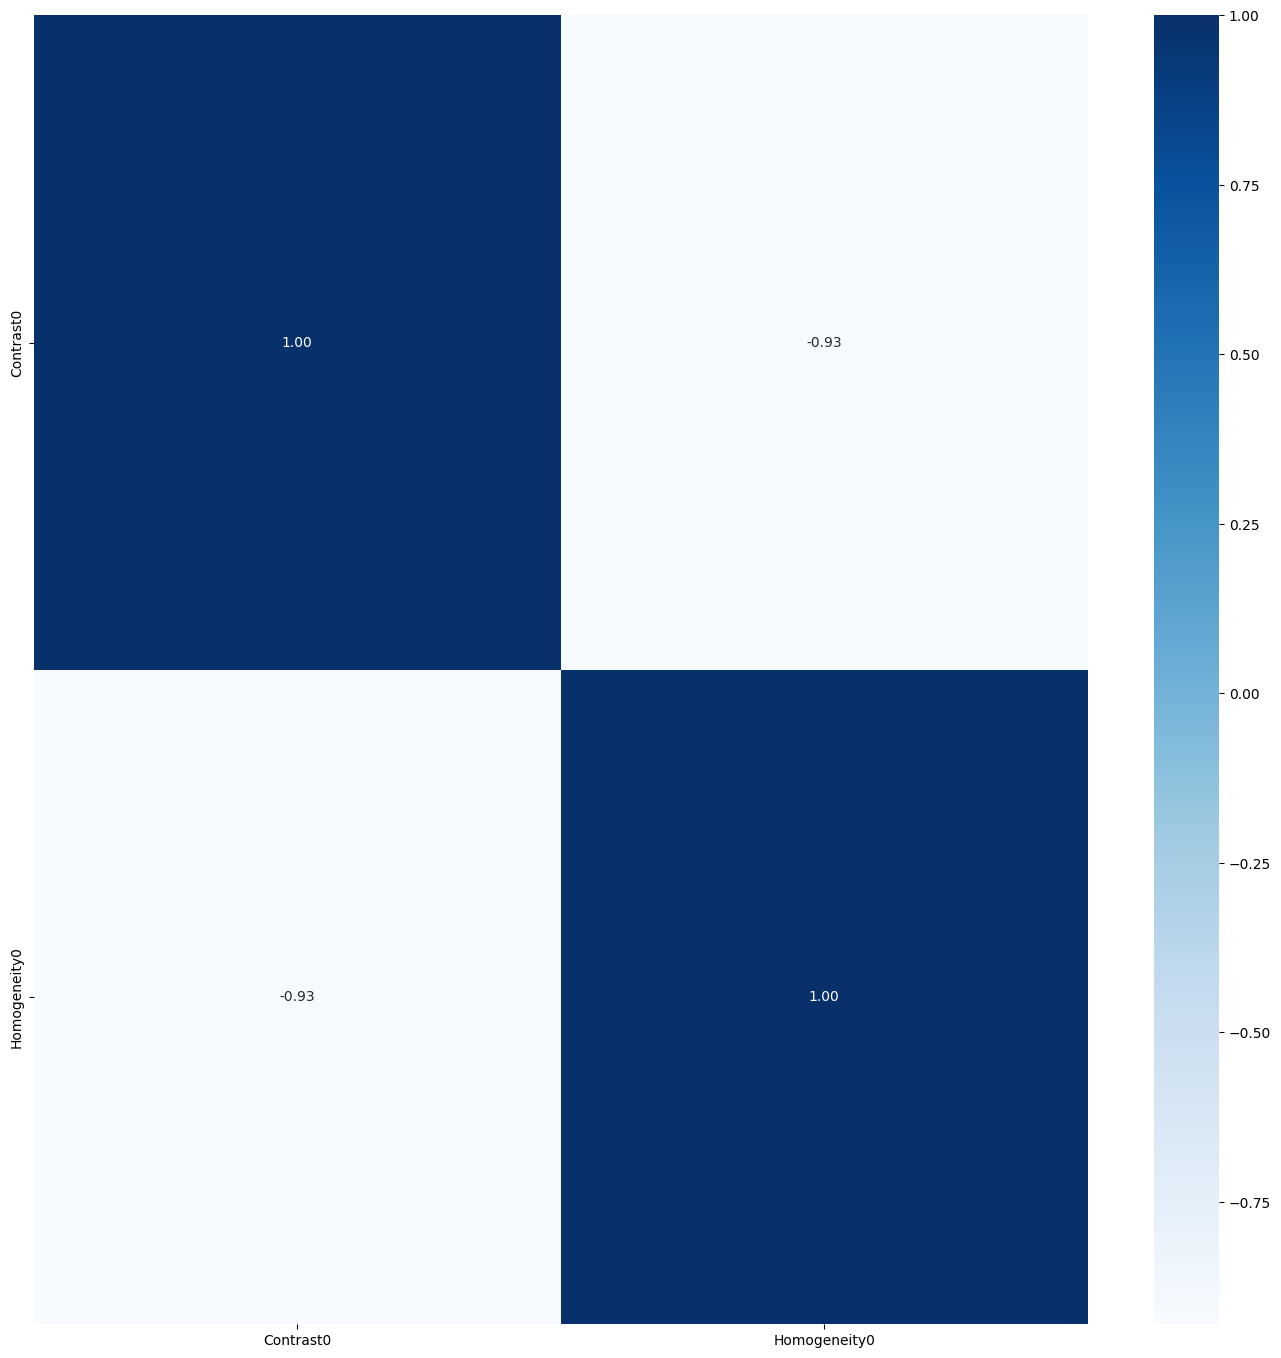

In [26]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [27]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(1584, 2)
(396, 2)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [28]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [29]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [30]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.88      0.56      0.69       391
              Grape___Esca_(Black_Measles)       0.90      0.39      0.54       397
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.93      0.39      0.55       393
                           Grape___healthy       0.38      0.95      0.55       403

                                  accuracy                           0.58      1584
                                 macro avg       0.77      0.57      0.58      1584
                              weighted avg       0.77      0.58      0.58      1584

[[220   3   3 165]
 [ 13 155   3 226]
 [ 11   6 155 221]
 [  7   9   5 382]]
Accuracy: 0.5757575757575758

------Testing Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.42      0.34      0.37       104


### Train SVM Classifier

In [31]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.45      0.36      0.40       391
              Grape___Esca_(Black_Measles)       0.00      0.00      0.00       397
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.53      0.18      0.27       393
                           Grape___healthy       0.29      0.81      0.42       403

                                  accuracy                           0.34      1584
                                 macro avg       0.32      0.34      0.27      1584
                              weighted avg       0.32      0.34      0.27      1584

[[140   0  22 229]
 [ 79   0  21 297]
 [ 32   0  70 291]
 [ 57   0  19 327]]
Accuracy: 0.3390151515151515

------Testing Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.42      0.38      0.40       104

c:\Users\ROG FLOWX13\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ROG FLOWX13\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ROG FLOWX13\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

### Train KNN Classifier

In [32]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.29      0.83      0.43       391
              Grape___Esca_(Black_Measles)       0.57      0.26      0.35       397
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.61      0.24      0.35       393
                           Grape___healthy       0.59      0.20      0.30       403

                                  accuracy                           0.38      1584
                                 macro avg       0.52      0.38      0.36      1584
                              weighted avg       0.52      0.38      0.36      1584

[[323  26  22  20]
 [267 102  15  13]
 [255  21  95  22]
 [271  29  23  80]]
Accuracy: 0.3787878787878788

------Testing Set------
                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.27      0.76      0.39       104

## Evaluation With Confusion Matrix

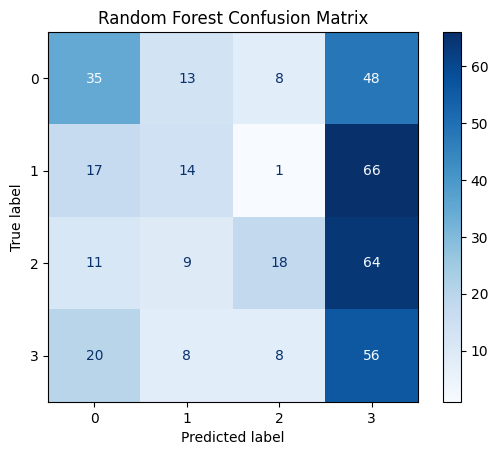

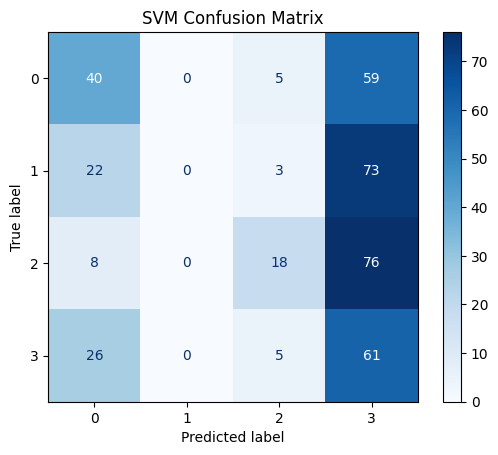

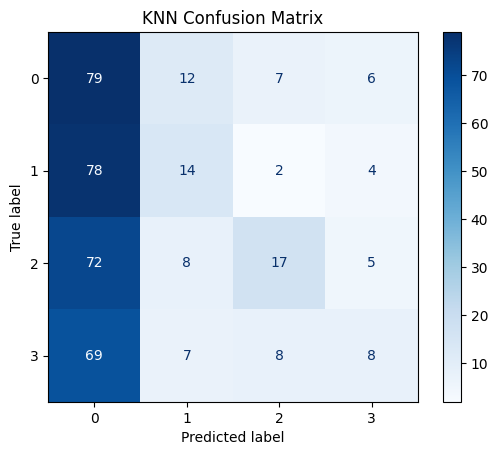

In [33]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")